<a href="https://colab.research.google.com/github/vedrocks15/Dance_Form_Classifier/blob/master/DanceForms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading Zipped ( Both Train & Test )

In [ ]:
! ls

sample_data


In [ ]:
from google.colab import files
files.upload()

Saving 0664343c9a8f11ea.zip to 0664343c9a8f11ea.zip


In [ ]:
! unzip '0664343c9a8f11ea.zip'

Archive:  0664343c9a8f11ea.zip
   creating: dataset/
   creating: dataset/test/
  inflating: dataset/test/508.jpg    
  inflating: dataset/test/246.jpg    
  inflating: dataset/test/473.jpg    
  inflating: dataset/test/485.jpg    
  inflating: dataset/test/128.jpg    
  inflating: dataset/test/410.jpg    
  inflating: dataset/test/465.jpg    
  inflating: dataset/test/196.jpg    
  inflating: dataset/test/340.jpg    
  inflating: dataset/test/467.jpg    
  inflating: dataset/test/306.jpg    
  inflating: dataset/test/171.jpg    
  inflating: dataset/test/323.jpg    
  inflating: dataset/test/332.jpg    
  inflating: dataset/test/330.jpg    
  inflating: dataset/test/170.jpg    
  inflating: dataset/test/479.jpg    
  inflating: dataset/test/9.jpg      
  inflating: dataset/test/283.jpg    
  inflating: dataset/test/114.jpg    
  inflating: dataset/test/507.jpg    
  inflating: dataset/test/183.jpg    
  inflating: dataset/test/200.jpg    
  inflating: dataset/test/457.jpg    
  inflat

# Data labelwise division for ImageGenerator

In [ ]:
import pandas as pd
import os,shutil
df_train = pd.read_csv("dataset/train.csv")
df_test  = pd.read_csv("dataset/test.csv")
print("Train set :",len(df_train))
print("Test  set :",len(df_test))
new_train_path  = "dataset/Train/"
new_train_image = "dataset/train/"

Train set : 364
Test  set : 156


# Sanity Check 
Done in order to ensure that each image in train path has a label

In [ ]:
! ls dataset/train/ | wc -l

364


In [ ]:
! ls dataset/test | wc -l

156


In [ ]:
! mkdir dataset/Train

mkdir: cannot create directory ‘dataset/Train’: File exists


In [ ]:
# Storing train half based on the labels provided by the pandas file & directory name is label name
for _,r in df_train.groupby(df_train["target"]):
    tmp = new_train_path

    style = list(set(r["target"]))
    img   = list(r["Image"])

    tmp+=style[0]
    if os.path.exists(tmp):
        shutil.rmtree(tmp)
    os.mkdir(tmp)

    # copying all files
    for fname in img:
        src = os.path.join(new_train_image,fname)
        des = os.path.join(tmp,fname)
        shutil.copyfile(src,des)

In [ ]:
! ls dataset/Train

bharatanatyam  kathakali  manipuri	odissi
kathak	       kuchipudi  mohiniyattam	sattriya


In [ ]:
import tensorflow as tf
# used for image visualization
import matplotlib.pyplot as plt
#used for creating the train test and augmenting the data
from keras.preprocessing.image import ImageDataGenerator
#efficient for model deployment on mobile
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import regularizers
print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [ ]:
# using the only directory we create a split
training_directory = "dataset/Train/"

# mobile net limitation
img_size = 299
batch_len = 32

# adding all these details only for train

t_d = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range = 0.5,
    height_shift_range = 0.5,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split=0.12) # 15% validation split
"""
t_d=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split=0.12)
"""

train_data = t_d.flow_from_directory(
    training_directory,
    target_size = (img_size,img_size),
    batch_size = batch_len ,
    class_mode="categorical",
    subset = "training")

val_data = t_d.flow_from_directory(
    training_directory,
    target_size = (img_size,img_size),
    batch_size = batch_len ,
    class_mode="categorical",
    subset = "validation")


Found 324 images belonging to 8 classes.
Found 40 images belonging to 8 classes.


In [ ]:
img_1,label_1 = train_data[0]
img_1.shape,label_1.shape  #labels are 1 - 0 therefore 32 is the size of batch label
label_names = list(train_data.class_indices.keys())
print(label_names)
len(train_data)

['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri', 'mohiniyattam', 'odissi', 'sattriya']


11

In [ ]:
! mkdir log_dir

mkdir: cannot create directory ‘log_dir’: File exists


In [ ]:
initial_rate = 1e-4
decay = 0.00025

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return initial_rate * (1/(1+decay*epoch))

class callback_handle(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('val_accuracy') > 0.95):
      print("Reached 99% validation accuracy")
      self.model.stop_training = True
    
callbacks_list = [
                  tf.keras.callbacks.EarlyStopping(
                      monitor = 'val_accuracy',
                      patience = 11             #12 back to back epochs constant accuracy (validation)
                  ),
                  tf.keras.callbacks.ModelCheckpoint(
                      filepath = 'dance_form.h5',
                      monitor = "val_loss",     # based on the validation loss metric we only over-write the h5 file if it improves
                      save_best_only = True,
                  ),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor = 'val_loss',
                      factor = 0.1,
                      patience = 8, # if validation does not improve for 8 epochs then LR falls by 10
                   ),
                  tf.keras.callbacks.TensorBoard(
                      log_dir='log_dir',
                      histogram_freq = 1, # progress of activations throughout the training
                  ),
                  callback_handle(),
                  #tf.keras.callbacks.LearningRateScheduler(scheduler)
]

In [ ]:
new_img_shape = (img_size,img_size,3)
new_base_model = tf.keras.applications.InceptionV3(input_shape=new_img_shape,
                         include_top=False,
                        weights="imagenet")
new_base_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
new_base_model.trainable = True # train only the fully connected layers this prevents heavy gradients to damage already learnt weights

# Classical Head

In [ ]:
#,kernel_regularizer=regularizers.l2(0.1)
model = tf.keras.Sequential([
            new_base_model,
            #tf.keras.layers.Flatten(),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(128,activation="relu",kernel_regularizer=regularizers.l2(0.0001)),
            tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4,momentum = 0.9),  #since multiple classes therefore the loss function is categorical cross entropy
              loss='categorical_crossentropy', 
              metrics=['accuracy'],)

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_63 (Dense)             (None, 8)                 520       
Total params: 21,934,440
Trainable params: 21,900,008
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
tf.executing_eagerly()

True

In [ ]:
epochs = 100
history = model.fit(train_data, 
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    epochs=epochs,
                    callbacks = callbacks_list)

Epoch 1/100
11/11 [==============================] - 19s 2s/step - loss: 0.4704 - accuracy: 0.8951 - val_loss: 0.7393 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - 17s 2s/step - loss: 0.4102 - accuracy: 0.9136 - val_loss: 0.8599 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - 18s 2s/step - loss: 0.4975 - accuracy: 0.8981 - val_loss: 0.8647 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 4/100
11/11 [==============================] - 18s 2s/step - loss: 0.4518 - accuracy: 0.9043 - val_loss: 0.6829 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 5/100
11/11 [==============================] - 17s 2s/step - loss: 0.4033 - accuracy: 0.9228 - val_loss: 0.9611 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 6/100
11/11 [==============================] - 18s 2s/step - loss: 0.4590 - accuracy: 0.9012 - val_loss: 0.6233 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 7/100
11/11 [==============================] -

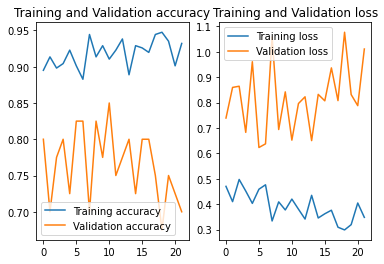

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()

kathak


'\n# HeatMAP\nclass_idx          = np.argmax(res)\ndance_output       = model.output[:,class_idx]\nfinal_conv_layer   = model.get_layer(\'conv2d_96\') #(batch, 8, 8, 192)\ngradient_model     = Model(inputs  =[model.inputs],\n                           outputs =[final_conv_layer.output,model.output])\n\nwith tf.GradientTape() as tape:\n  inputs = tf.cast(image,tf.float32)\n  (convOutputs , predictions) = gradient_model(inputs)\n  loss = predictions[:,class_idx]\n\ngrads = tape.gradient(loss, convOutputs)\ncastConvOutputs = tf.cast(convOutputs > 0, "float32")\ncastGrads = tf.cast(grads > 0, "float32")\nguidedGrads = castConvOutputs * castGrads * grads\n\nconvOutputs = convOutputs[0]\nguidedGrads = guidedGrads[0]\n\nweights = tf.reduce_mean(guidedGrads, axis=(0, 1))\ncam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)\n\n(w, h) = (image.shape[2], image.shape[1])\nheatmap = cv2.resize(cam.numpy(), (w, h))\n\n\nnumer = heatmap - np.min(heatmap)\ndenom = (heatmap.max() - heatmap.

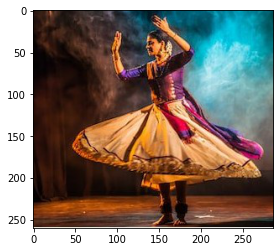

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img               # function that helps in image loading
from keras.preprocessing.image import img_to_array           # conversion of an image to a numpy array
import numpy as np
from tensorflow.keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras import Model

# displaying the test image
test_num = 6
path = "dataset/test/"+str(test_num)+".jpg"
img1 = mpimg.imread(path)
f , ax1 = plt.subplots(1,1)
ax1.imshow(img1)

# prediction result
image = load_img(path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image/= 255

res = model.predict(image)
print(label_names[np.argmax(res)])

"""
# HeatMAP
class_idx          = np.argmax(res)
dance_output       = model.output[:,class_idx]
final_conv_layer   = model.get_layer('conv2d_96') #(batch, 8, 8, 192)
gradient_model     = Model(inputs  =[model.inputs],
                           outputs =[final_conv_layer.output,model.output])

with tf.GradientTape() as tape:
  inputs = tf.cast(image,tf.float32)
  (convOutputs , predictions) = gradient_model(inputs)
  loss = predictions[:,class_idx]

grads = tape.gradient(loss, convOutputs)
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

convOutputs = convOutputs[0]
guidedGrads = guidedGrads[0]

weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

(w, h) = (image.shape[2], image.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))


numer = heatmap - np.min(heatmap)
denom = (heatmap.max() - heatmap.min()) + 1e-8
heatmap = numer / denom
heatmap = (heatmap * 255).astype("uint8")

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
alpha = 0.5
#output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

cv2_imshow(heatmap)
"""

# Prediction & GradCam Visualization

# CSV formating of solution

In [ ]:
from os import listdir
import pandas as pd
result = pd.DataFrame([],columns=['Image','target'])
directory = "dataset/test/"
new_model = tf.keras.models.load_model('dance_form.h5')

i = 0
for name in listdir(directory):

  # load an image from file
  filename = directory + '/' + name
  image = load_img(filename, target_size=(img_size, img_size))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image/= 255
  res = new_model.predict(image)
  label_res = label_names[np.argmax(res)]
  result.loc[i] = [name,label_res]
  i+=1

 
print(result)
result.to_csv('result.csv',index=False)


       Image         target
0    232.jpg      kathakali
1    429.jpg      kuchipudi
2    411.jpg      kuchipudi
3     20.jpg         kathak
4    175.jpg         kathak
..       ...            ...
151  421.jpg         odissi
152  162.jpg  bharatanatyam
153   95.jpg       manipuri
154  119.jpg  bharatanatyam
155  146.jpg  bharatanatyam

[156 rows x 2 columns]


In [ ]:
! ls -l
! mkdir weights

total 1251140
-rw-r--r-- 1 root root   27882564 Jul  4 01:32 0664343c9a8f11ea.zip
-rw-r--r-- 1 root root 1253258768 Jul  4 03:31 dance_form.h5
drwxr-xr-x 5 root root       4096 Jul  4 01:35 dataset
drwxr-xr-x 4 root root       4096 Jul  4 01:36 log_dir
-rw-r--r-- 1 root root       2752 Jul  4 03:54 result.csv
drwxr-xr-x 1 root root       4096 Jun 26 16:26 sample_data


In [ ]:
from google.colab import files
files.download("result.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cp dance_form.h5 weights/

In [ ]:
! zip -r wei.zip weights/

  adding: weights/ (stored 0%)
  adding: weights/dance_form.h5 (deflated 7%)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
! ls gdrive/'My Drive'
! cp dance_form.h5 gdrive/'My Drive'

 1704.04861.pdf
'2017batch-SDP-Assignment (1).gsheet'
'2017batch-SDP-Assignment (1).xlsx'
'2017batch-SDP-Assignment (2).gsheet'
 2017batch-SDP-Assignment.gsheet
 2017batch-SDP-Assignment.xlsx
'2017BCS0065 (1).zip'
'2017BCS0065 (2).zip'
'2017BCS0065 (3).zip'
'2017BCS0065 (4).zip'
 2017BCS0065.zip
 20200204-110231-227666-0.avi
 20200204-111133-076640-0.avi
'8086_Chap 3_1.gslides'
'8086_Chap 3_1.pptx'
'Amita Kapoor - Hands-On Artificial Intelligence for IoT_ Expert machine learning and deep learning techniques for developing smarter IoT systems (2019, Packt Publishing).pdf'
 ASS.tar.gz
'autonomous track.docx'
'autonomous track.gdoc'
'BTech_hon_1 (1).pptx'
 BTech_hon_1.gslides
 BTech_hon_1.pptx
 BTech_hon_2.gslides
 BTech_hon_2.pptx
'Campus Visit.xlsx'
 Classroom
'Class work problems-1(MA-IV).pdf'
 close_flight_single_coconut.avi
'coco_layers (4).pdf'
 code2.py
'Colab Notebooks'
 drone_doc.pages
'Duane P. Schultz, Sydney Ellen Schultz-Theories of Personality-Wadsworth Publishing (2004).pdf

# Model Load & Predict

In [ ]:
# upload the dance_form.h5 file attached with this zip folder
from google.colab import files
files.upload()

In [ ]:
new_model = tf.keras.models.load_model('dance_form.h5')
new_model.summary()

# Path for the training image
path = ""

# prediction result
image = load_img(path, target_size=(img_size, img_size))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image/= 255

res = model.predict(image)
print(label_names[np.argmax(res)])
